# Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # For prototyping
import lightgbm as lgb  # Final model choice

# Set Up Display Options

In [4]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
%matplotlib inline

# Load the Synthetic Burnout Dataset

In [10]:
# Load the real dataset (ensure 'dataset.csv' is in your working directory)
data = pd.read_csv('dataset.csv')

# Preview the first 5 rows
data.head()

,user_id,date,sleep_hours,work_hours,screen_time_hours,heart_rate_avg,steps,burnout_label
0,U001,2024-01-01,7.38,7.78,5.01,67.7,5598,Low
1,U001,2024-01-02,7.62,5.59,2.28,67.8,4623,Low
2,U001,2024-01-03,7.66,6.80,1.86,67.5,7844,Low
3,U001,2024-01-04,7.23,7.61,2.85,71.5,5447,Low
4,U001,2024-01-05,5.88,7.98,5.81,75.9,6637,Moderate


#  Basic Dataset Exploration

In [11]:
# Check the shape and basic info
print("Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nInfo:")
data.info()

# Check for missing values
print("\nMissing values:\n", data.isnull().sum())

# Check target distribution
print("\nBurnout label distribution:\n", data['burnout_label'].value_counts(normalize=True))


Shape: (4500, 8)

Columns: ['user_id', 'date', 'sleep_hours', 'work_hours', 'screen_time_hours', 'heart_rate_avg', 'steps', 'burnout_label']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            4500 non-null   object 
 1   date               4500 non-null   object 
 2   sleep_hours        4500 non-null   float64
 3   work_hours         4500 non-null   float64
 4   screen_time_hours  4500 non-null   float64
 5   heart_rate_avg     4500 non-null   float64
 6   steps              4500 non-null   int64  
 7   burnout_label      4500 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 281.4+ KB

Missing values:
 user_id              0
date                 0
sleep_hours          0
work_hours           0
screen_time_hours    0
heart_rate_avg       0
steps                0
burnout_label        0


# Visualize a Key Wellness Metric (Sleep Hours Example)

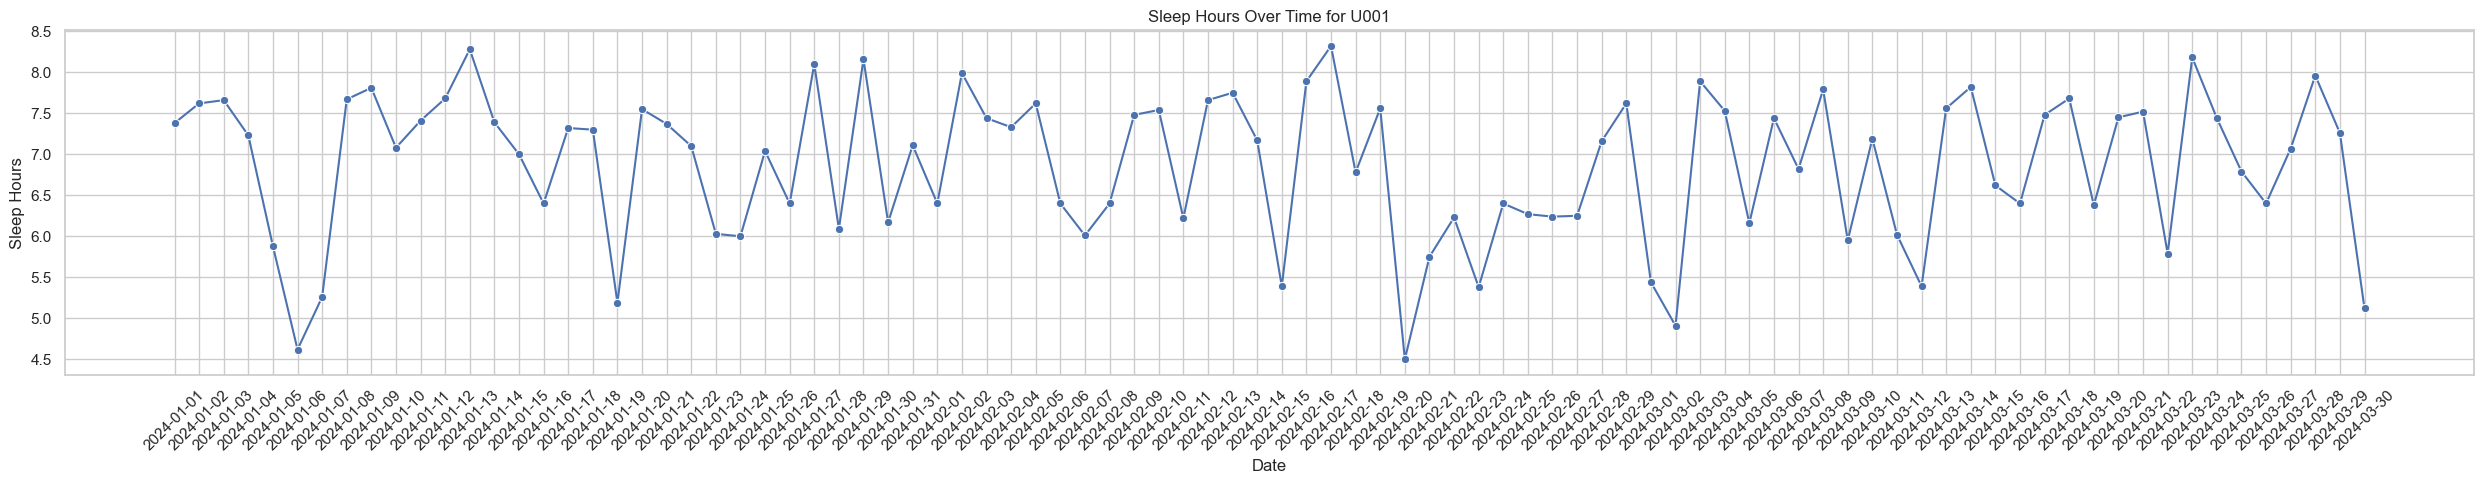

In [18]:
# Plot average sleep hours over time for a sample user
sample_user = data['user_id'].unique()[0]
user_data = data[data['user_id'] == sample_user]

plt.figure(figsize=(25,5))
sns.lineplot(x='date', y='sleep_hours', data=user_data, marker='o')
plt.title(f'Sleep Hours Over Time for {sample_user}')
plt.xlabel('Date')
plt.ylabel('Sleep Hours')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Saved a Clean Copy for Reuse

In [19]:
# Save a clean copy (if you make changes later)
data.to_csv("burnout_dataset_clean.csv", index=False)

# Feature Engineering: Rolling, Ratio, and Cumulative Features

In [20]:
# Ensure date is datetime and data is sorted for rolling calculations
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['user_id', 'date']).reset_index(drop=True)

# Rolling window size (7 days)
rolling_window = 7

# Rolling mean and variance for each user and key features
for feature in ['sleep_hours', 'work_hours', 'screen_time_hours', 'heart_rate_avg']:
    data[f'{feature}_rolling_mean'] = data.groupby('user_id')[feature].transform(
        lambda x: x.rolling(rolling_window, min_periods=1).mean())
    data[f'{feature}_rolling_var'] = data.groupby('user_id')[feature].transform(
        lambda x: x.rolling(rolling_window, min_periods=1).var())

# Work to sleep ratio (work_hours / sleep_hours)
data['work_sleep_ratio'] = data['work_hours'] / data['sleep_hours']

# Screen time to steps ratio (add 1 to avoid division by zero)
data['screen_steps_ratio'] = data['screen_time_hours'] / (data['steps'] + 1)

# Cumulative work hours per user (shows workload accumulation)
data['cumulative_work_hours'] = data.groupby('user_id')['work_hours'].cumsum()

data.head()

,user_id,date,sleep_hours,work_hours,screen_time_hours,heart_rate_avg,steps,burnout_label,sleep_hours_rolling_mean,sleep_hours_rolling_var,work_hours_rolling_mean,work_hours_rolling_var,screen_time_hours_rolling_mean,screen_time_hours_rolling_var,heart_rate_avg_rolling_mean,heart_rate_avg_rolling_var,work_sleep_ratio,screen_steps_ratio,cumulative_work_hours
0,U001,2024-01-01,7.38,7.78,5.01,67.7,5598,Low,7.380000,NaN,7.780000,NaN,5.010,NaN,67.700000,NaN,1.054201,0.000895,7.78
1,U001,2024-01-02,7.62,5.59,2.28,67.8,4623,Low,7.500000,0.028800,6.685000,2.398050,3.645,3.72645,67.750000,0.005000,0.733596,0.000493,13.37
2,U001,2024-01-03,7.66,6.80,1.86,67.5,7844,Low,7.553333,0.022933,6.723333,1.203433,3.050,2.92530,67.666667,0.023333,0.887728,0.000237,20.17
3,U001,2024-01-04,7.23,7.61,2.85,71.5,5447,Low,7.472500,0.041425,6.945000,0.998833,3.000,1.96020,68.625000,3.689167,1.052559,0.000523,27.78
4,U001,2024-01-05,5.88,7.98,5.81,75.9,6637,Moderate,7.154000,0.538280,7.152000,0.963370,3.562,3.04937,70.080000,13.352000,1.357143,0.000875,35.76


1. The rolling mean columns (like sleep_hours_rolling_mean) show the user’s average sleep over the past week, updating each day. This highlights short-term trends and helps identify periods of chronic sleep deprivation or recovery
2. The rolling variance columns (like work_hours_rolling_var) indicate how much the user’s work hours have fluctuated over the same period, which can signal instability in workload.
3. These engineered features are calculated separately for each user and are essential for capturing patterns that may not be obvious from single-day values alone.
4. For the first few days, some variance values are missing (NaN) because there isn’t enough past data to compute them—this is normal for rolling calculations.

# Exploratory Data Analysis (EDA): Visualizing Feature Distributions

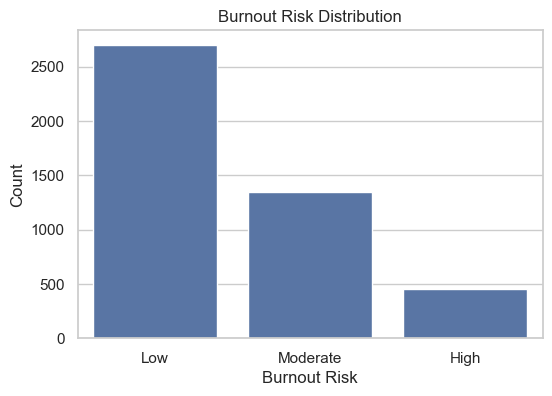

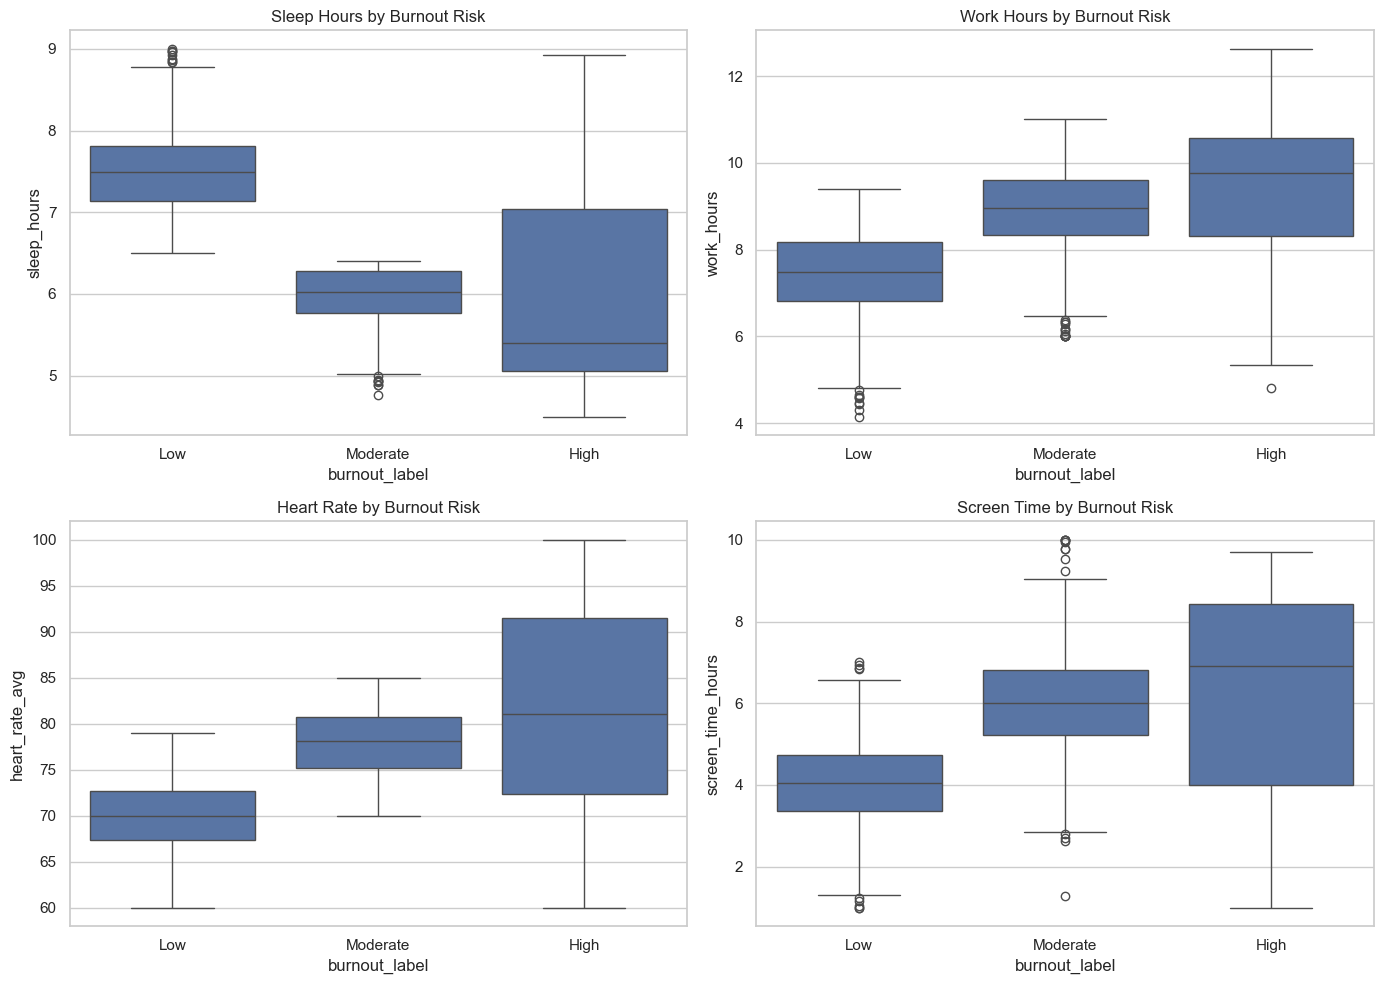

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Burnout label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='burnout_label', data=data)
plt.title('Burnout Risk Distribution')
plt.xlabel('Burnout Risk')
plt.ylabel('Count')
plt.show()

# Boxplots to visualize key features by burnout risk
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(x='burnout_label', y='sleep_hours', data=data, ax=axes[0,0])
axes[0,0].set_title('Sleep Hours by Burnout Risk')

sns.boxplot(x='burnout_label', y='work_hours', data=data, ax=axes[0,1])
axes[0,1].set_title('Work Hours by Burnout Risk')

sns.boxplot(x='burnout_label', y='heart_rate_avg', data=data, ax=axes[1,0])
axes[1,0].set_title('Heart Rate by Burnout Risk')

sns.boxplot(x='burnout_label', y='screen_time_hours', data=data, ax=axes[1,1])
axes[1,1].set_title('Screen Time by Burnout Risk')

plt.tight_layout()
plt.show()

1. Countplot checks label balance for modeling.
2. Boxplots show how each key feature varies across burnout risk levels, validating your feature engineering logic and the relationships in your synthetic data.

## Label Encoding and Train-Test Split

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode burnout_label to numerical values
le = LabelEncoder()
data['burnout_label_encoded'] = le.fit_transform(data['burnout_label'])

# Select features for modeling
feature_cols = [
    'sleep_hours', 'work_hours', 'screen_time_hours', 'heart_rate_avg', 'steps',
    'sleep_hours_rolling_mean', 'sleep_hours_rolling_var',
    'work_hours_rolling_mean', 'work_hours_rolling_var',
    'screen_time_hours_rolling_mean', 'screen_time_hours_rolling_var',
    'heart_rate_avg_rolling_mean', 'heart_rate_avg_rolling_var',
    'work_sleep_ratio', 'screen_steps_ratio', 'cumulative_work_hours'
]

X = data[feature_cols]
y = data['burnout_label_encoded']

# Stratified split to maintain label proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (3600, 16), Test shape: (900, 16)


1. LabelEncoder converts categorical burnout risk to numbers for ML.
2. Stratified train-test split preserves the class distribution, which is crucial for fair evaluation, especially with imbalanced classes

## Baseline Model: Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

        High       1.00      0.98      0.99        90
         Low       1.00      1.00      1.00       540
    Moderate       0.99      1.00      1.00       270

    accuracy                           1.00       900
   macro avg       1.00      0.99      1.00       900
weighted avg       1.00      1.00      1.00       900

Confusion Matrix:
 [[ 88   0   2]
 [  0 540   0]
 [  0   0 270]]


1. Random Forest is a robust baseline for tabular health data and can handle non-linear feature interactions.
2. Classification report gives precision, recall, and F1 for each risk level.
3. Confusion matrix helps visualize misclassification patterns and overall model performance (Synthetic dataset is being used)

# Feature Importance Visualization

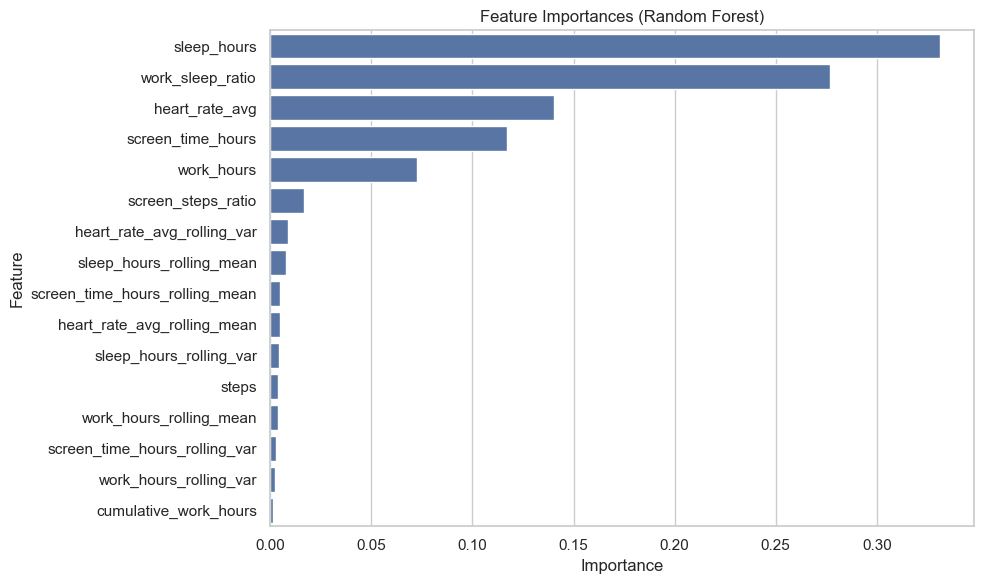

In [27]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

This plot shows which features most influence burnout risk predictions, guiding further feature engineering and model refinement.